<a href="https://colab.research.google.com/github/Akshita-8/Lanslide-Risk-Assessment/blob/main/LandSlideDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Creator:Anusha
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import copy
import random
from PIL import Image
import shutil
from urllib.request import urlretrieve
import os
import cv2
import time

In [ ]:
# Creator:Anusha
import glob
from tqdm import tqdm
from torchvision.datasets import OxfordIIITPet
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, ConcatDataset
from torchvision import transforms
import torchvision.transforms as tt

In [ ]:
# # Creator:Pallavi
# !pip install gdown
# !pip install segmentation-models-pytorch

In [ ]:
# Creator:Pallavi
!gdown --id 1dDeJW1Lt5T188hnJNQH0sINWCXL3slZ2

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1dDeJW1Lt5T188hnJNQH0sINWCXL3slZ2
From (redirected): https://drive.google.com/uc?id=1dDeJW1Lt5T188hnJNQH0sINWCXL3slZ2&confirm=t&uuid=721246c9-2a53-4328-af3c-367c308c0e21
To: /content/archive.zip
100% 526M/526M [00:11<00:00, 47.2MB/s]


In [ ]:
# Creator:Pallavi
!unzip archive.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/Bijie-landslide-dataset/landslide/mask/qxg095.png  
  inflating: /content/Bijie-landslide-dataset/landslide/mask/qxg096.png  
  inflating: /content/Bijie-landslide-dataset/landslide/mask/qxg097.png  
  inflating: /content/Bijie-landslide-dataset/landslide/mask/qxg098.png  
  inflating: /content/Bijie-landslide-dataset/landslide/mask/qxg099.png  
  inflating: /content/Bijie-landslide-dataset/landslide/mask/qxg100.png  
  inflating: /content/Bijie-landslide-dataset/landslide/mask/qxg101.png  
  inflating: /content/Bijie-landslide-dataset/landslide/mask/qxg102.png  
  inflating: /content/Bijie-landslide-dataset/landslide/mask/qxg103.png  
  inflating: /content/Bijie-landslide-dataset/landslide/mask/qxg104.png  
  inflating: /content/Bijie-landslide-dataset/landslide/mask/qxg105.png  
  inflating: /content/Bijie-landslide-dataset/landslide/mask/qxg106.png  
  inflating: /content/Bijie-landslide-dataset/landslide/mask/

In [ ]:
# Creator:Pallavi
import os
os.listdir('/content/')

['.config', 'Bijie-landslide-dataset', 'archive.zip', 'sample_data']

In [ ]:
# Creator:Anusha
# Modified : Pallavi
import zipfile
zip_path = '/content/archive.zip'
extract_path = '/content/dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed. Contents:")
print(os.listdir(extract_path))

Extraction completed. Contents:
['Bijie-landslide-dataset']


In [ ]:
import os
from sklearn.model_selection import train_test_split
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Paths to image and mask directories
image_dir = "/content/dataset/Bijie-landslide-dataset/landslide/image"
mask_dir = "/content/dataset/Bijie-landslide-dataset/landslide/mask"

# Retrieve and sort file paths
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))])
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(('.jpg', '.png'))])

# Ensure alignment of images and masks
assert len(image_files) == len(mask_files), "Mismatch in the number of images and masks!"
images = [os.path.join(image_dir, f) for f in image_files]
masks = [os.path.join(mask_dir, f) for f in mask_files]

# Split data into train, validation, and test sets
train_images, test_images, train_masks, test_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

train_images, val_images, train_masks, val_masks = train_test_split(
    train_images, train_masks, test_size=0.2, random_state=42
)

print(f"Training images: {len(train_images)}, Validation images: {len(val_images)}, Test images: {len(test_images)}")

# Dataset Class
class LandslideDataset(Dataset):
    def __init__(self, image_paths, mask_paths, target_size=(512, 512), is_train=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.target_size = target_size
        self.is_train = is_train

        # Define augmentations
        self.transform_train = A.Compose([
            A.Resize(*self.target_size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])

        self.transform_val = A.Compose([
            A.Resize(*self.target_size),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Read image and mask
        image = cv2.imread(self.image_paths[idx])[:, :, ::-1]  # Convert BGR to RGB
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        if self.is_train:
            augmented = self.transform_train(image=image, mask=mask)
        else:
            augmented = self.transform_val(image=image, mask=mask)

        image = augmented['image']
        mask = augmented['mask'].unsqueeze(0) / 255.0  # Normalize mask

        return image, mask

# Define datasets
train_dataset = LandslideDataset(train_images, train_masks, target_size=(512, 512), is_train=True)
val_dataset = LandslideDataset(val_images, val_masks, target_size=(512, 512), is_train=False)
test_dataset = LandslideDataset(test_images, test_masks, target_size=(512, 512), is_train=False)

# Define data loaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

print("Data preparation complete. Ready for training!")


Training images: 492, Validation images: 124, Test images: 154
Data preparation complete. Ready for training!


In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class ConvBlock(nn.Module):
#     """Convolutional block with BatchNorm and ReLU activation."""
#     def __init__(self, in_channels, out_channels, use_se=False):
#         super(ConvBlock, self).__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#         )
#         self.use_se = use_se
#         if use_se:
#             self.se = SqueezeExcitation(out_channels)

#     def forward(self, x):
#         x = self.conv(x)
#         if self.use_se:
#             x = self.se(x)
#         return x


# class SqueezeExcitation(nn.Module):
#     """Squeeze-and-Excitation block for channel-wise attention."""
#     def __init__(self, channels, reduction=16):
#         super(SqueezeExcitation, self).__init__()
#         self.fc = nn.Sequential(
#             nn.AdaptiveAvgPool2d(1),
#             nn.Conv2d(channels, channels // reduction, kernel_size=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(channels // reduction, channels, kernel_size=1),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         scale = self.fc(x)
#         return x * scale


# class LinkNetEncoder(nn.Module):
#     """Encoder consisting of downsampling ConvBlocks."""
#     def __init__(self, in_channels, filters=(64, 128, 256, 512)):
#         super(LinkNetEncoder, self).__init__()
#         self.initial = nn.Sequential(
#             nn.Conv2d(in_channels, filters[0], kernel_size=7, stride=2, padding=3, bias=False),
#             nn.BatchNorm2d(filters[0]),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2)  # 4x downsampling
#         )

#         # Encoder Blocks
#         self.enc1 = ConvBlock(filters[0], filters[1])
#         self.enc2 = ConvBlock(filters[1], filters[2])
#         self.enc3 = ConvBlock(filters[2], filters[3])

#     def forward(self, x):
#         x0 = self.initial(x)  # Downsampled 4x
#         x1 = self.enc1(x0)   # 8x
#         x2 = self.enc2(x1)   # 16x
#         x3 = self.enc3(x2)   # 32x
#         return x0, x1, x2, x3


# import torch.nn.functional as F

# class LinkNetDecoder(nn.Module):
#     def __init__(self, filters):
#         super(LinkNetDecoder, self).__init__()
#         self.up3 = nn.ConvTranspose2d(filters[3], filters[2], kernel_size=2, stride=2)
#         self.dec3 = ConvBlock(filters[2] + filters[2], filters[2])

#         self.up2 = nn.ConvTranspose2d(filters[2], filters[1], kernel_size=2, stride=2)
#         self.dec2 = ConvBlock(filters[1] + filters[1], filters[1])

#         self.up1 = nn.ConvTranspose2d(filters[1], filters[0], kernel_size=2, stride=2)
#         self.dec1 = ConvBlock(filters[0] + filters[0], filters[0])

#         self.final = nn.Conv2d(filters[0], 1, kernel_size=1)

#     def forward(self, x0, x1, x2, x3):
#         d3 = self.up3(x3)
#         d3 = F.interpolate(d3, size=x2.shape[2:], mode="bilinear", align_corners=False)
#         d3 = torch.cat((d3, x2), dim=1)
#         d3 = self.dec3(d3)

#         d2 = self.up2(d3)
#         d2 = F.interpolate(d2, size=x1.shape[2:], mode="bilinear", align_corners=False)
#         d2 = torch.cat((d2, x1), dim=1)
#         d2 = self.dec2(d2)

#         d1 = self.up1(d2)
#         d1 = F.interpolate(d1, size=x0.shape[2:], mode="bilinear", align_corners=False)
#         d1 = torch.cat((d1, x0), dim=1)
#         d1 = self.dec1(d1)

#         out = self.final(d1)
#         out = F.interpolate(out, scale_factor=4, mode="bilinear", align_corners=False)
#         return out




# class LinkNet(nn.Module):
#     """LinkNet combining Encoder and Decoder."""
#     def __init__(self, num_classes=1, in_channels=3, filters=(64, 128, 256, 512), use_se=False):
#         super(LinkNet, self).__init__()
#         self.encoder = LinkNetEncoder(in_channels, filters)
#         self.decoder = LinkNetDecoder(filters)
#         self.use_se = use_se

#         if use_se:  # Apply SE blocks in encoder if requested
#             self.encoder.enc1 = ConvBlock(filters[0], filters[1], use_se=True)
#             self.encoder.enc2 = ConvBlock(filters[1], filters[2], use_se=True)
#             self.encoder.enc3 = ConvBlock(filters[2], filters[3], use_se=True)

#     def forward(self, x):
#         x0, x1, x2, x3 = self.encoder(x)
#         out = self.decoder(x0, x1, x2, x3)
#         out = F.interpolate(out, size=x.shape[2:], mode="bilinear", align_corners=False)  # Resize to input
#         return out


# # Example Usage
# if __name__ == "__main__":
#     batch_size = 4
#     input_channels = 3
#     image_height, image_width = 1024, 1024

#     model = LinkNet(num_classes=1, in_channels=input_channels, use_se=True)
#     sample_input = torch.randn(batch_size, input_channels, image_height, image_width)

#     output = model(sample_input)
#     print("Input shape:", sample_input.shape)
#     print("Output shape:", output.shape)


Input shape: torch.Size([4, 3, 1024, 1024])
Output shape: torch.Size([4, 1, 1024, 1024])


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

# LinkNet with Pretrained ResNet Encoder
class LinkNet(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(LinkNet, self).__init__()

        # Load ResNet as Encoder
        resnet = models.resnet34(pretrained=pretrained)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # Remove FC and AvgPool layers

        # Custom Decoder Layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),  # Upsample by factor of 2
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, num_classes, kernel_size=1)  # Final output layer
        )

        # Optional: Freeze ResNet Layers (if you want to use pre-trained features only)
        for param in self.encoder.parameters():
            param.requires_grad = False  # Freeze pretrained layers

    def forward(self, x):
        # Encoder
        x = self.encoder(x)

        # Decoder (Upsampling)
        x = self.decoder(x)

        # Use F.interpolate to resize the output to the target size (e.g., 512x512)
        x = F.interpolate(x, size=(512, 512), mode='bilinear', align_corners=False)

        return x

# Example usage
if __name__ == "__main__":
    model = LinkNet(num_classes=1).to("cuda" if torch.cuda.is_available() else "cpu")
    print(model)


LinkNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_model(model, train_loader, val_loader, num_epochs=30, lr=1e-3, model_save_dir="content/saved_models", device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    os.makedirs(model_save_dir, exist_ok=True)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    scaler = torch.cuda.amp.GradScaler()  # Mixed precision
    best_val_loss = float('inf')

    model = model.to(device)
    model = model.float()  # Ensure model weights are in float32

    # Logs to store loss for each epoch
    train_losses = []
    val_losses = []

    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch [{epoch}/{num_epochs}]")

        # Training Phase
        model.train()
        train_loss = 0.0
        for images, masks in tqdm(train_loader, desc="Training", leave=False):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast(dtype=torch.float32):  # Use mixed precision (ensure float32)
                outputs = model(images)
                loss = criterion(outputs, masks)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        print(f"Training Loss: {train_loss:.4f}")
        train_losses.append(train_loss)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc="Validation", leave=False):
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Validation Loss: {val_loss:.4f}")
        val_losses.append(val_loss)

        # Update learning rate
        scheduler.step(val_loss)

        # Save Best Model based on Validation Loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(model_save_dir, "best_model.pth"))
            print("✅ Saved Best Model based on Validation Loss!")

        # Optionally, save model after every epoch
        torch.save(model.state_dict(), os.path.join(model_save_dir, f"model_epoch_{epoch}.pth"))
        print(f"✅ Saved Model after Epoch {epoch}")

    print("Training Complete!")

    # Optionally, return loss logs for plotting or analysis
    return train_losses, val_losses


In [ ]:
train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=30, lr=1e-3, model_save_dir="content/saved_models", device="cuda")



Epoch [1/30]


Training Loss: 0.2729


Validation Loss: 0.2764
Model saved!

Epoch [2/30]


Training Loss: 0.2569


Validation Loss: 0.2448
Model saved!

Epoch [3/30]


Training Loss: nan


Validation Loss: nan

Epoch [4/30]


Training Loss: nan


Validation Loss: nan

Epoch [5/30]


Training Loss: nan


Validation Loss: nan

Epoch [6/30]


Training Loss: nan


Validation Loss: nan

Epoch [7/30]


Training Loss: nan


Validation Loss: nan

Epoch [8/30]


Training Loss: nan


Validation Loss: nan

Epoch [9/30]


Training Loss: nan


Validation Loss: nan

Epoch [10/30]


Training Loss: nan


Validation Loss: nan

Epoch [11/30]


Training Loss: nan


Validation Loss: nan

Epoch [12/30]


Training Loss: nan


Validation Loss: nan

Epoch [13/30]


Training Loss: nan


Validation Loss: nan

Epoch [14/30]


Training Loss: nan


Validation Loss: nan

Epoch [15/30]


Training Loss: nan


Validation Loss: nan

Epoch [16/30]


Training Loss: nan


Validation Loss: nan

Epoch [17/30]


Training Loss: nan


Validation Loss: nan

Epoch [18/30]


Training Loss: nan


Validation Loss: nan

Epoch [19/30]


Training Loss: nan


Validation Loss: nan

Epoch [20/30]


Training Loss: nan


Validation Loss: nan

Epoch [21/30]


Training Loss: nan


Validation Loss: nan

Epoch [22/30]


Training Loss: nan


Validation Loss: nan

Epoch [23/30]


Training Loss: nan


Validation Loss: nan

Epoch [24/30]


Training Loss: nan


Validation Loss: nan

Epoch [25/30]


Training Loss: nan


Validation Loss: nan

Epoch [26/30]


Training Loss: nan


Validation Loss: nan

Epoch [27/30]


Training Loss: nan


Validation Loss: nan

Epoch [28/30]


Training Loss: nan


Validation Loss: nan

Epoch [29/30]


Training Loss: nan


Validation Loss: nan

Epoch [30/30]


Training Loss: nan


Validation Loss: nan
Training Complete!


<ipython-input-38-3df777f532cb>:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_model_path, map_location="cuda"))  # Use 'cuda' if

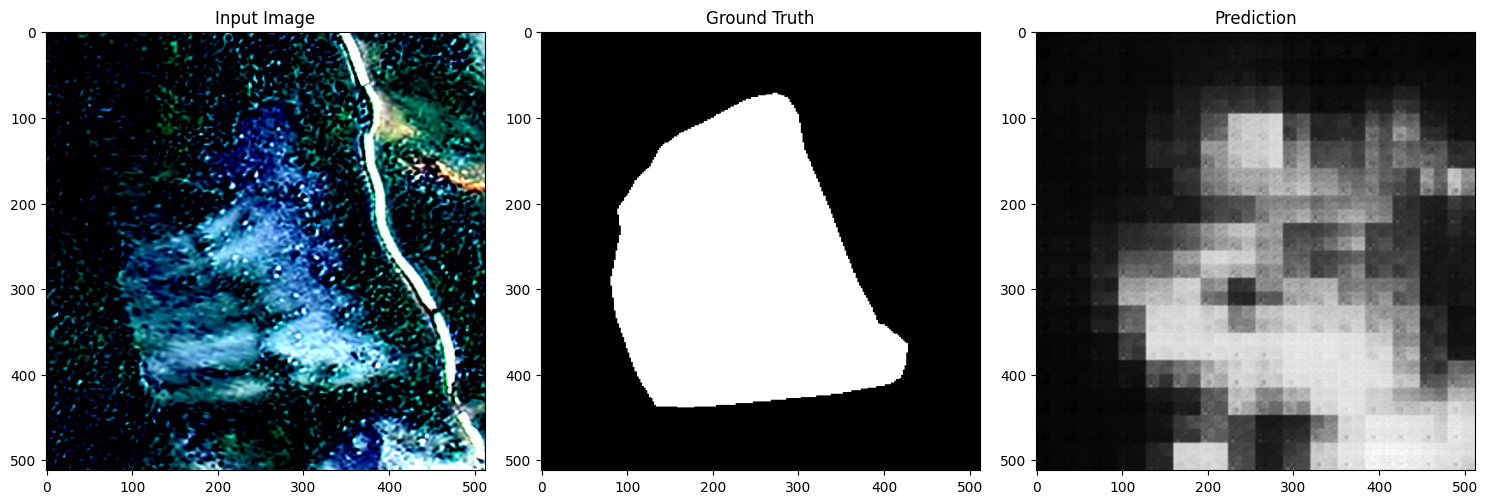

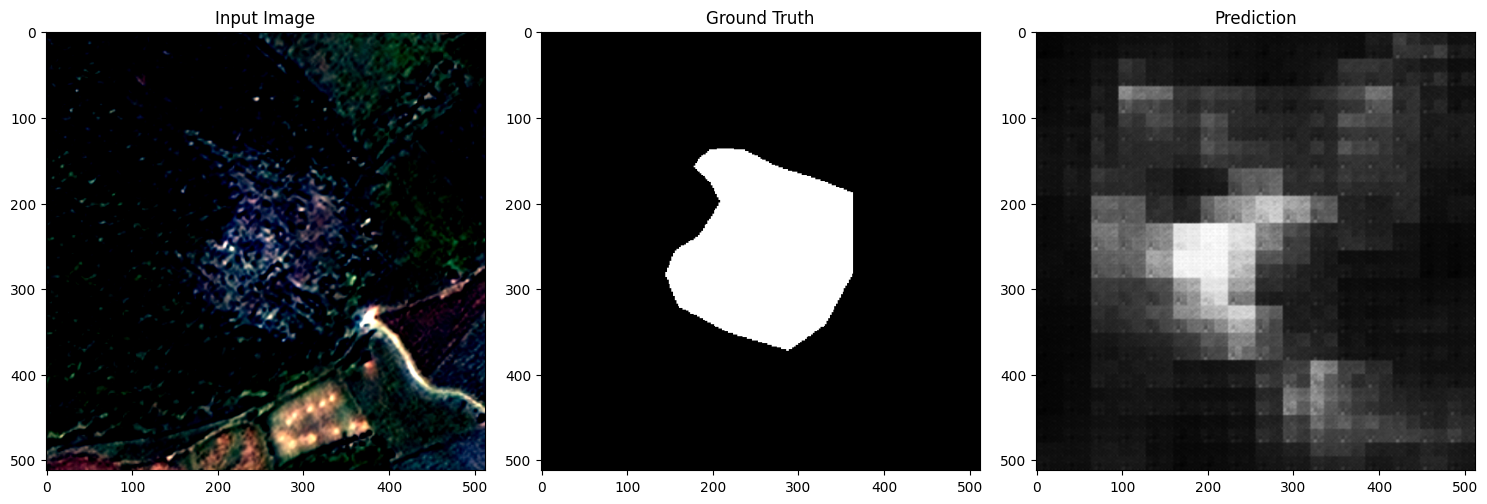

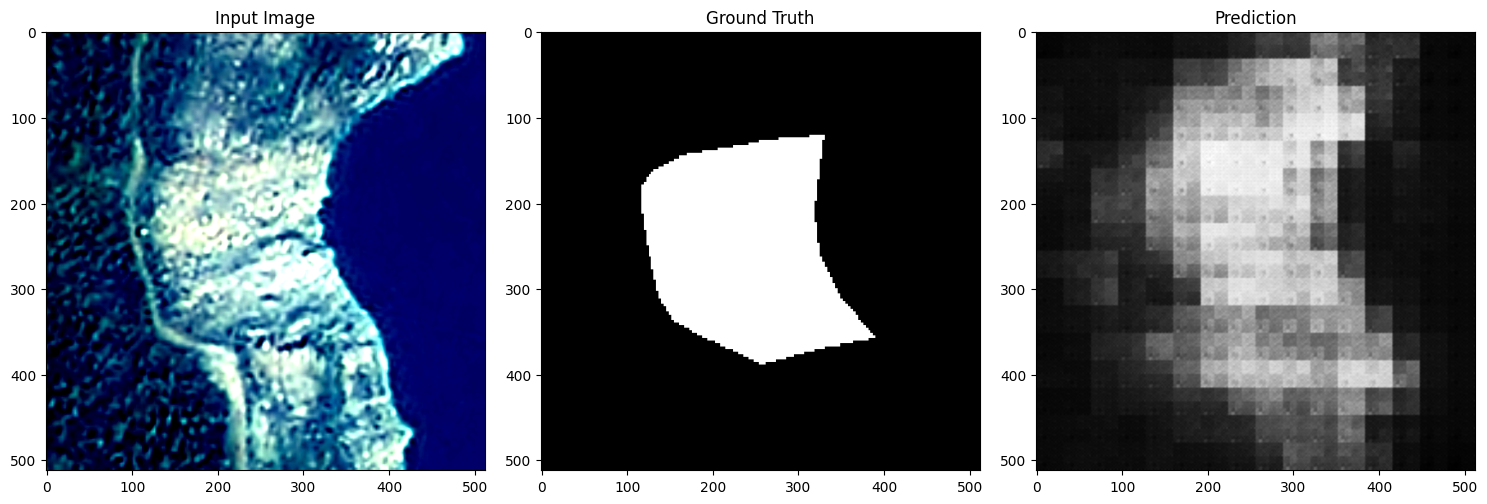

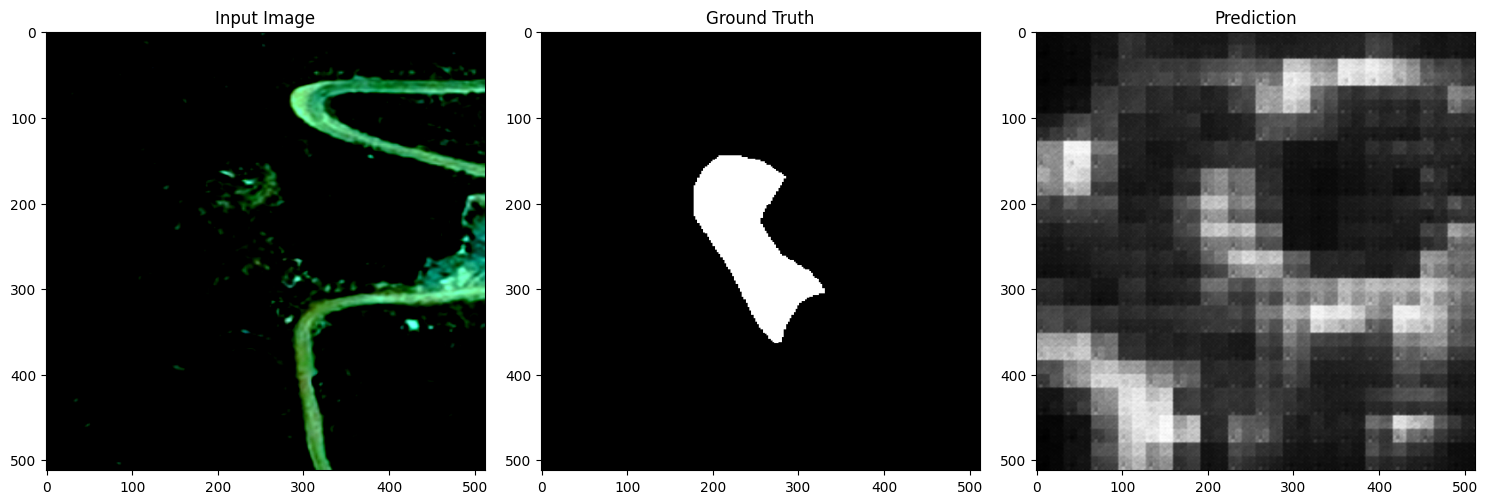

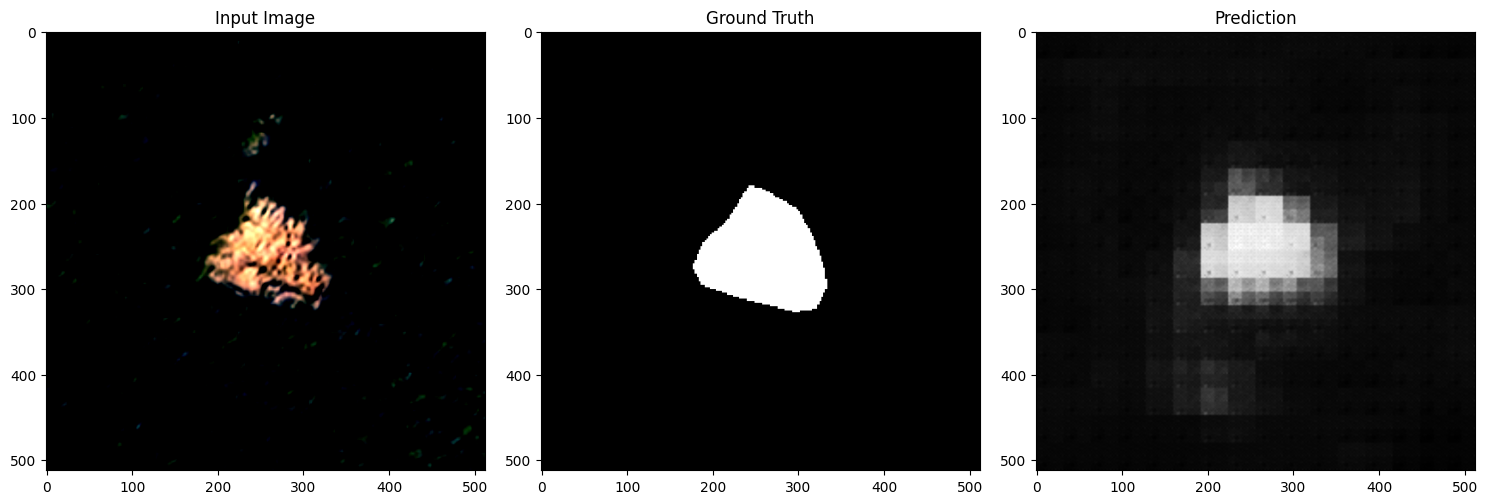

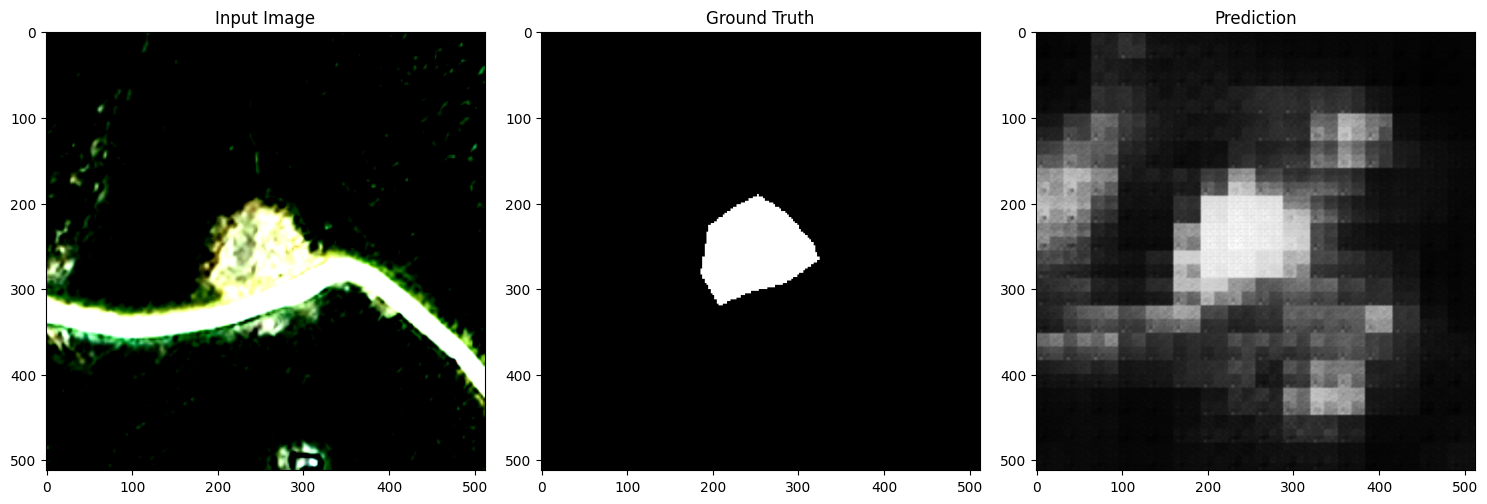

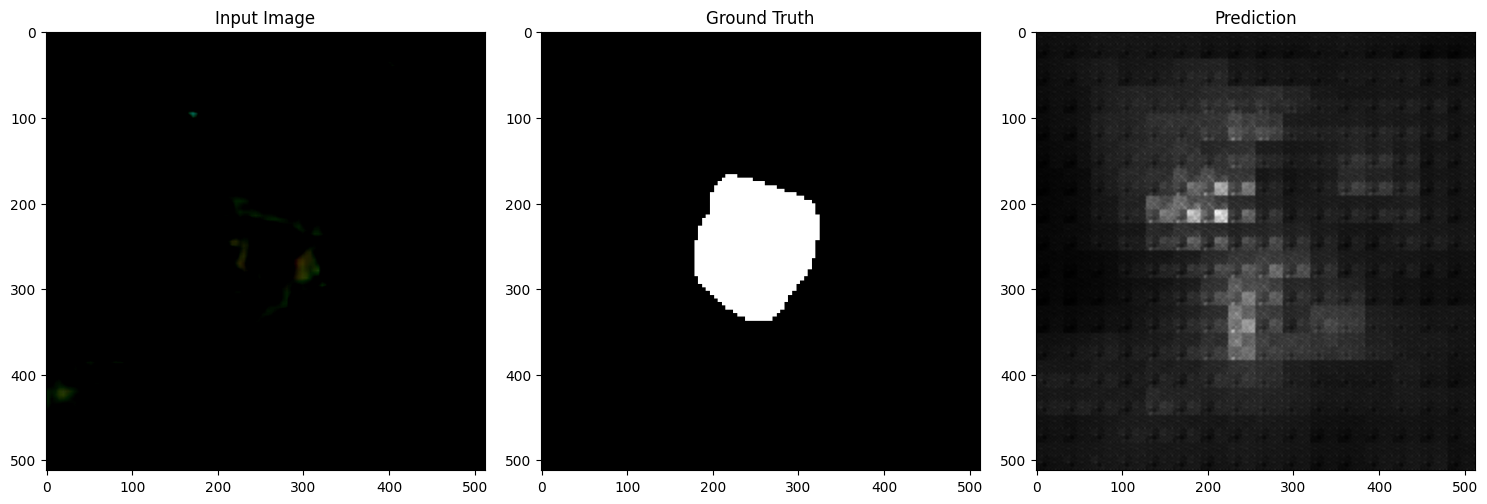

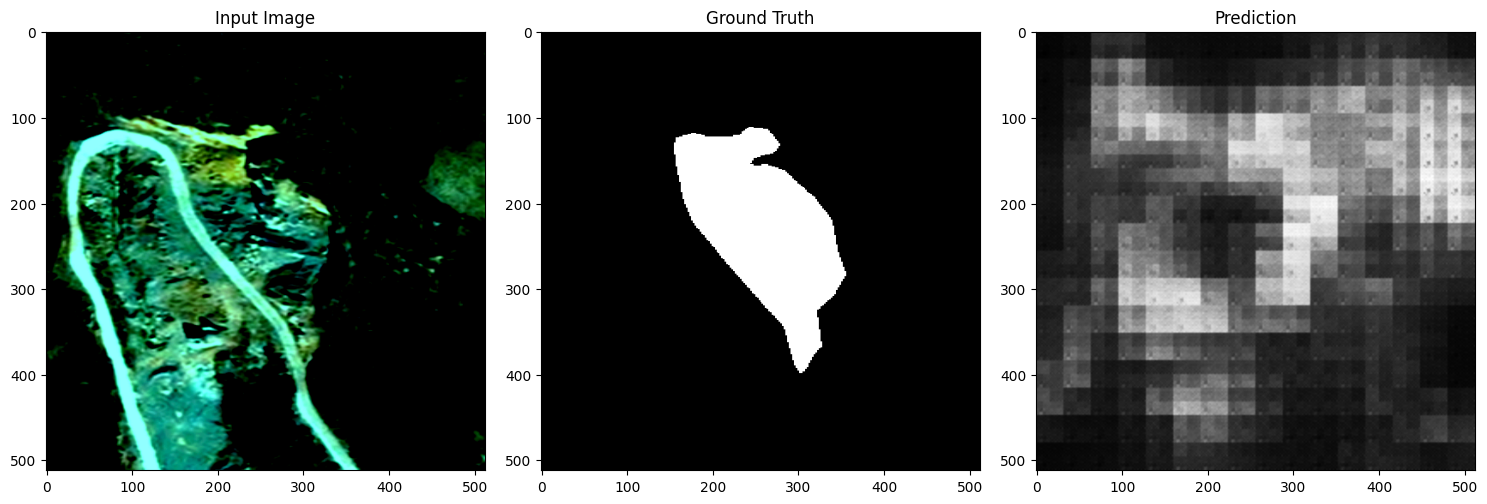

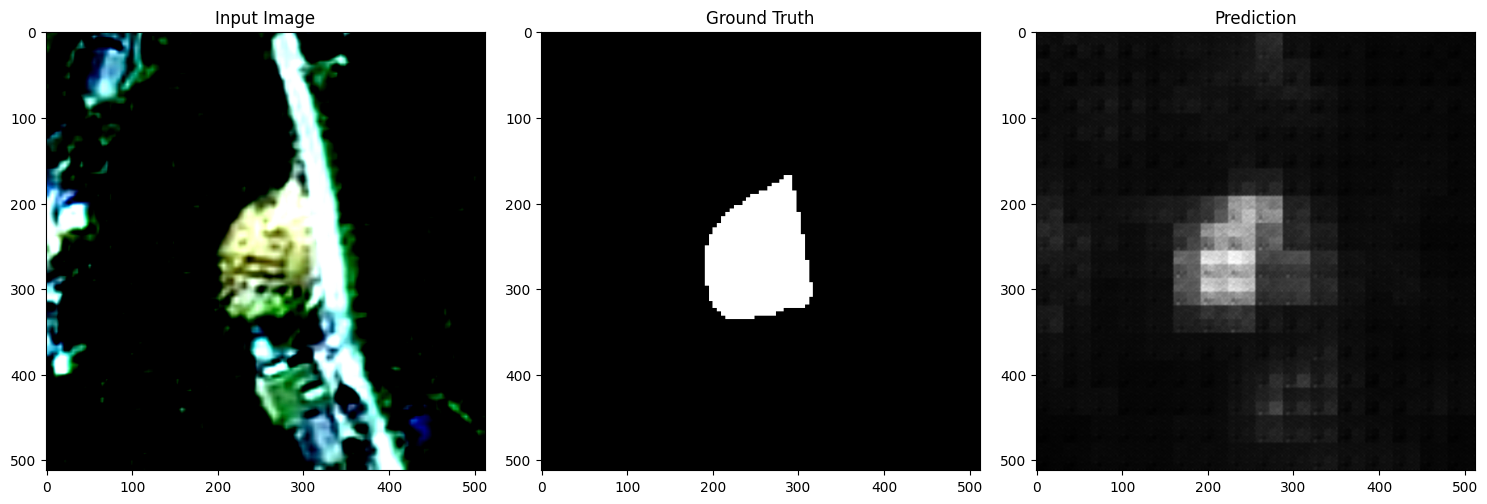

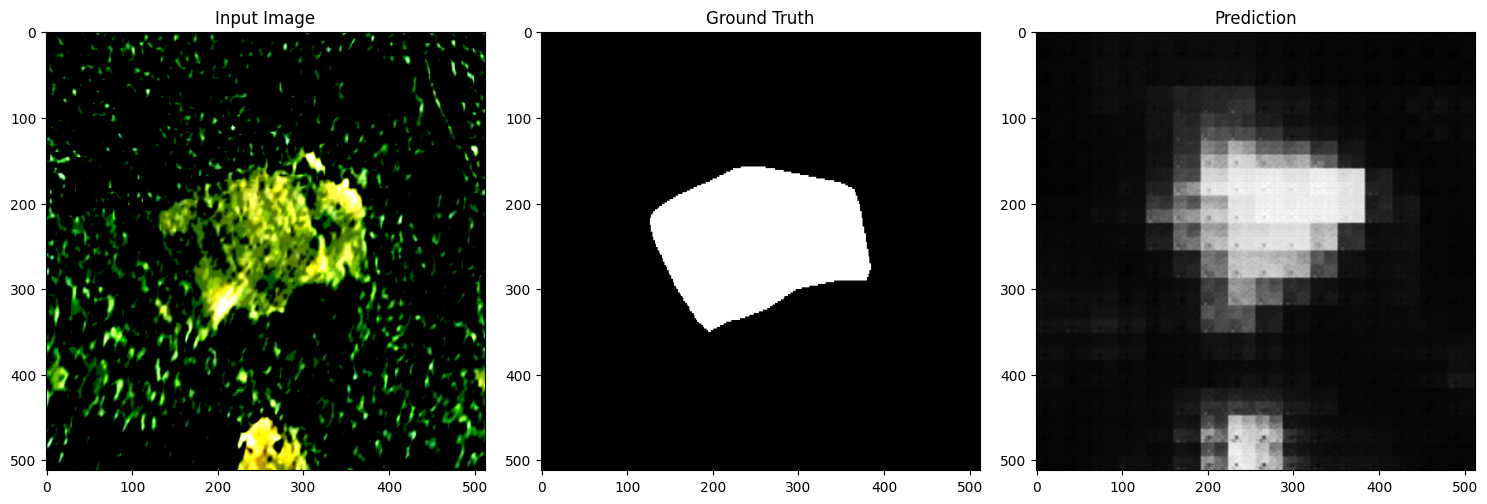

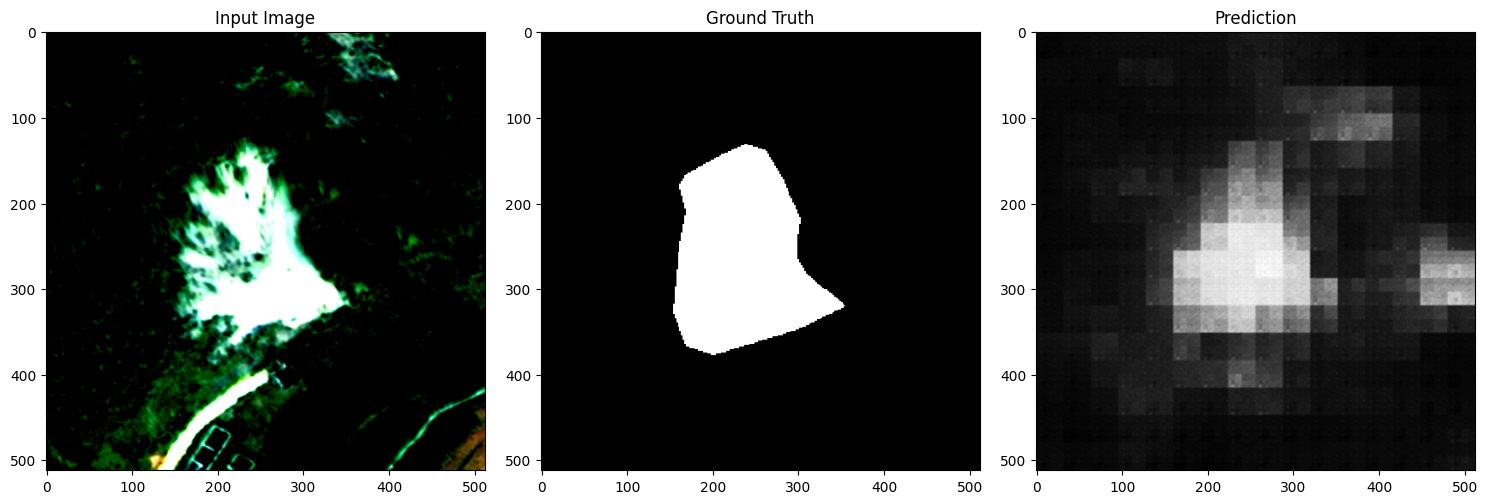

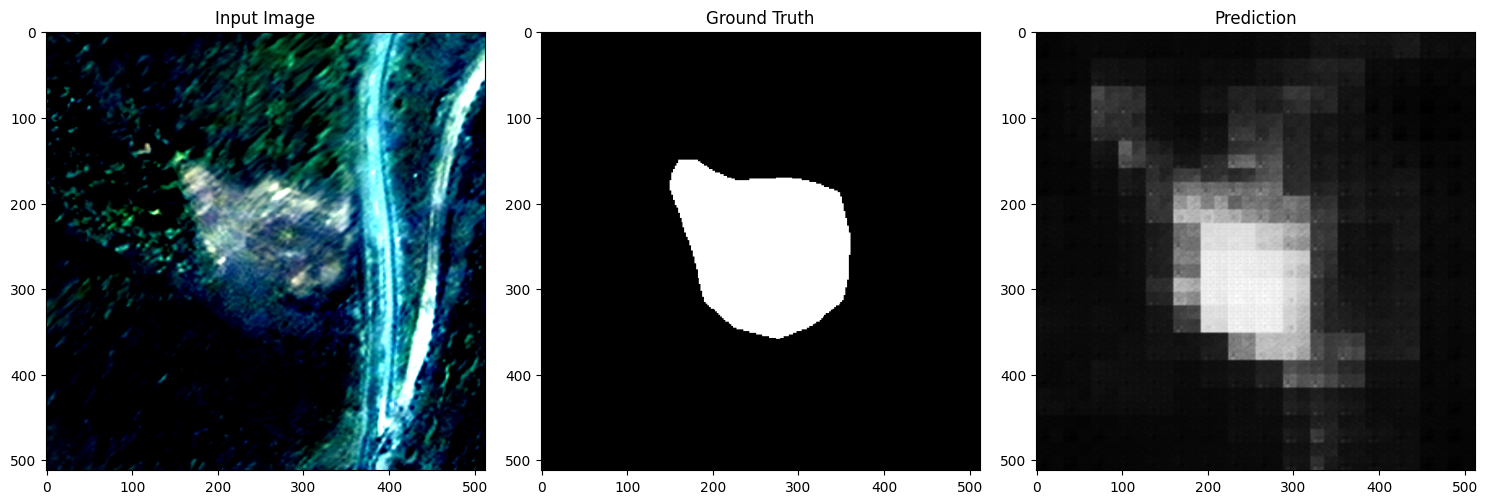

Predictions displayed.


In [ ]:
# import os
# import torch
# import matplotlib.pyplot as plt

# # Path to your saved model and output directory
# trained_model_path = "/content/content/saved_models/best_model.pth"  # Update with your saved model path
# output_dir = "/content/predictions"
# os.makedirs(output_dir, exist_ok=True)

# # Load the trained model
# model = LinkNet(num_classes=1, in_channels=3)
# model.load_state_dict(torch.load(trained_model_path, map_location="cuda"))  # Use 'cuda' if GPU is available
# model.eval()

# # Function to save prediction images
# def save_predictions(images, masks, predictions, idx):
#     for i in range(len(images)):
#         input_image = images[i].permute(1, 2, 0).numpy()  # Convert CHW to HWC
#         ground_truth = masks[i].squeeze(0).numpy()  # Squeeze single channel
#         prediction = predictions[i].squeeze(0).numpy()

#         fig, ax = plt.subplots(1, 3, figsize=(15, 5))
#         ax[0].imshow(input_image)
#         ax[0].set_title("Input Image")
#         ax[1].imshow(ground_truth, cmap="gray")
#         ax[1].set_title("Ground Truth")
#         ax[2].imshow(prediction, cmap="gray")
#         ax[2].set_title("Prediction")
#         plt.tight_layout()

#         output_file = os.path.join(output_dir, f"prediction_{idx + i}.png")
#         plt.savefig(output_file)
#         plt.close()

# # Test the model and save the first 10 predictions
# with torch.no_grad():
#     for idx, (images, masks) in enumerate(test_loader):
#         if idx * len(images) >= 10:  # Stop after saving 10 predictions
#             break

#         images, masks = images, masks  # Move to CPU or GPU if needed
#         predictions = model(images)
#         predictions = torch.sigmoid(predictions)  # Normalize logits to probabilities

#         save_predictions(images, masks, predictions, idx * len(images))

# print(f"Predictions saved in folder: {output_dir}")
import os
import torch
import matplotlib.pyplot as plt

# Path to your saved model and output directory
trained_model_path = "/content/content/saved_models/model_epoch_2.pth"  # Update with your saved model path

# Load the trained model
model = LinkNet(num_classes=1)
model.load_state_dict(torch.load(trained_model_path, map_location="cuda"))  # Use 'cuda' if GPU is available
model.eval()

# Function to display prediction images
def display_predictions(images, masks, predictions, idx):
    for i in range(len(images)):
        input_image = images[i].cpu().numpy()  # Keep images in RGB format (CHW -> CHW, no permute)
        ground_truth = masks[i].squeeze(0).cpu().numpy()  # Squeeze single channel
        prediction = predictions[i].squeeze(0).cpu().numpy()

        # Create a subplot with 3 images
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(input_image.transpose(1, 2, 0))  # Convert CHW to HWC for display
        ax[0].set_title("Input Image")
        ax[1].imshow(ground_truth, cmap="gray")
        ax[1].set_title("Ground Truth")
        ax[2].imshow(prediction, cmap="gray")
        ax[2].set_title("Prediction")
        plt.tight_layout()

        # Show the image
        plt.show()

# Test the model and display the first 10 predictions
with torch.no_grad():
    for idx, (images, masks) in enumerate(test_loader):
        if idx * len(images) >= 10:  # Stop after showing 10 predictions
            break

        images, masks = images, masks  # Move to CPU or GPU if needed
        predictions = model(images)
        predictions = torch.sigmoid(predictions)  # Normalize logits to probabilities

        display_predictions(images, masks, predictions, idx * len(images))

print("Predictions displayed.")



Using device: cuda


<ipython-input-15-50ec90bd7157>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(trained_model_path, map_location=device), strict=False)


Predictions saved in folder: predictions


In [ ]:
import os
import torch
import matplotlib.pyplot as plt

# Path to your saved model and output directory
trained_model_path = "/content/saved_models2/model_epoch_7.pth"  # Update with your model path
output_dir = "/content/predictions2"
os.makedirs(output_dir, exist_ok=True)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Check if the model file exists
if not os.path.exists(trained_model_path):
    raise FileNotFoundError(f"Model file not found at: {trained_model_path}")

# Load the trained model
model = LinkNet(num_classes=1, in_channels=3).to(device)  # Move model to GPU if available
model.load_state_dict(torch.load(trained_model_path, map_location=device))
model.eval()

# Function to save prediction images
def save_predictions(images, masks, predictions, idx):
    for i in range(len(images)):
        input_image = images[i].permute(1, 2, 0).cpu().numpy()  # Convert CHW to HWC
        ground_truth = masks[i].squeeze(0).cpu().numpy()  # Squeeze single channel
        prediction = predictions[i].squeeze(0).cpu().numpy()

        # Normalize predictions for visualization
        prediction = (prediction - prediction.min()) / (prediction.max() - prediction.min())

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(input_image)
        ax[0].set_title("Input Image")
        ax[1].imshow(ground_truth, cmap="gray")
        ax[1].set_title("Ground Truth")
        ax[2].imshow(prediction, cmap="gray")
        ax[2].set_title("Prediction")
        plt.tight_layout()

        output_file = os.path.join(output_dir, f"prediction_{idx + i}.png")
        plt.savefig(output_file)
        plt.close()
        print(f"Saved: {output_file}")

# Test the model and save the first 10 predictions
print("Starting predictions...")
with torch.no_grad():
    for idx, (images, masks) in enumerate(test_loader):
        print(f"Processing batch {idx + 1}...")
        if idx * len(images) >= 10:  # Stop after saving 10 predictions
            break

        # Move data to GPU if available
        images, masks = images.to(device), masks.to(device)
        predictions = model(images)
        predictions = torch.sigmoid(predictions)  # Normalize logits to probabilities

        save_predictions(images, masks, predictions, idx * len(images))

print(f"Predictions saved in folder: {output_dir}")


TypeError: LinkNet.__init__() got an unexpected keyword argument 'in_channels'

In [ ]:
# import os
# import torch
# from torchvision.utils import save_image

# # Directory to save results
# results_dir = "/content/training_results"
# os.makedirs(results_dir, exist_ok=True)

# # Number of epochs already trained
# trained_epochs = 7  # Replace with your actual number of epochs
# num_images_to_save = 10  # Number of images to track

# # Ensure model is in evaluation mode
# model.eval()

# # Save results for specific images across epochs
# with torch.no_grad():
#     for epoch in range(1, trained_epochs + 1):
#         print(f"Saving results for Epoch {epoch}...")

#         # Iterate through the validation dataset and save specific images
#         saved_images = 0
#         for i, (images, masks) in enumerate(test_loader):
#             if saved_images >= num_images_to_save:
#                 break

#             images = images.to(device)

#             # Forward pass to get predictions
#             predictions = model(images)
#             predictions = torch.sigmoid(predictions)  # Apply sigmoid for BCEWithLogitsLoss
#             predictions = (predictions > 0.5).float()  # Binarize output

#             # Save predictions for each image in its respective folder
#             for j in range(images.size(0)):
#                 if saved_images >= num_images_to_save:
#                     break

#                 # Create a folder for the specific image
#                 image_folder = os.path.join(results_dir, f"image_{saved_images + 1}")
#                 os.makedirs(image_folder, exist_ok=True)

#                 # Save the current epoch's result
#                 save_path = os.path.join(image_folder, f"epoch_{epoch}.png")
#                 save_image(predictions[j], save_path)

#                 saved_images += 1


Saving results for Epoch 1...
Saving results for Epoch 2...
Saving results for Epoch 3...
Saving results for Epoch 4...
Saving results for Epoch 5...
Saving results for Epoch 6...


KeyboardInterrupt: 

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Data augmentation
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
])

# Initialize the model and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LinkNet(num_classes=1).to(device)  # Binary segmentation (1 class)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Use BCE for binary segmentation
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# Directory for saved models
model_save_dir = "/content/saved_models2"  # Path to saved models
os.makedirs(model_save_dir, exist_ok=True)

# Load the last saved model
last_saved_model = os.path.join(model_save_dir, "model_epoch_12.pth")  # Adjust path if necessary
if os.path.exists(last_saved_model):
    print(f"Loading weights from: {last_saved_model}")
    model.load_state_dict(torch.load(last_saved_model, map_location=device))
else:
    print("No saved model found. Starting training from scratch.")

# Resume training parameters
num_epochs = 30  # Total number of epochs
best_val_loss = float('inf')  # Adjust if you know the previous best validation loss

for epoch in range(num_epochs):
    print(f"\n--- Epoch {epoch + 1}/{num_epochs} ---")

    # Training phase
    model.train()
    train_loss = 0.0
    for images, masks in tqdm(train_loader, desc="Training", leave=False):
        images, masks = images.to(device), masks.to(device)

        # Ensure masks have correct shape: (batch_size, 1, height, width)
        if len (masks.shape) == 3:
            masks = masks.unsqueeze(1)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, masks)

        # Backward pass and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    print(f"Training Loss: {train_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_masks in tqdm(val_loader, desc="Validation", leave=False):
            val_images, val_masks = val_images.to(device), val_masks.to(device)

            # Ensure masks have correct shape: (batch_size, 1, height, width)
            if len(val_masks.shape) == 3:
                val_masks = val_masks.unsqueeze(1)

            # Forward pass
            val_outputs = model(val_images)

            # Compute loss
            loss = criterion(val_outputs, val_masks)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(model_save_dir, "model_best.pth"))
        print("Saved Best Model")

    # Save the model every 3 epochs
    if (epoch + 1) % 3 == 0:
        torch.save(model.state_dict(), os.path.join(model_save_dir, f"model_epoch_{epoch + 1}.pth"))
        print(f"Saved Model at Epoch {epoch + 1}")

    # Step the scheduler
    scheduler.step(val_loss)

print("Training Complete!")